# Text Classification using LinearSVC and TfidfVectorizer

This Code Template is for Text Classification using LinearSVC based on the Support Vector Machine Algorithm along with the Text Feature technique TfidfVectorizer from Scikit-learn in python. One can import the TfidfVectorizer function from preprocessing class.

### Required Packages

In [ ]:
!pip install nltk
!pip install imblearn

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as se
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix,classification_report
from sklearn.svm import LinearSVC 

### Initialization

Filepath of CSV file

In [3]:
#filepath
file_path= ""

**Target** variable for prediction.

In [4]:
target=''

Text column containing all the text data


In [5]:
text=""

## Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [6]:
df=pd.read_csv(file_path)
df.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


### Data Preprocessing

The text data might contain noise in various forms like emotions, punctuation, text in a different case etc. We apply various text preprocessing methods such as converting text to lowercase, remove text in square brackets, remove links, remove special characters and remove words containing numbers to clean the text data and make it ready to feed data to the model.

We also apply lemmetization technique to the data which groups together the different canonical forms of a word so they can be analysed as a single item which ultimately improves model accuracy.

In [7]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)


#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

def textfinalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

def data_preprocess(df, target):
    df = df.dropna(axis=0, how = 'any')
    df[target] = LabelEncoder().fit_transform(df[target])    
    return df

In [8]:
df = data_preprocess(df, target)
df[text] = df[text].apply(lambda x: textfinalpreprocess(x))
df.head()

,ItemID,Sentiment,SentimentText
0,1,0,sad apl friend
1,2,0,miss new moon trailer
2,3,1,omg already
3,4,0,omgaga im sooo im gunna cry dentist since supo...
4,5,0,think mi bf cheat


### Feature Selections

It is the process of reducing the number of input variables when developing a predictive model. Used to reduce the number of input variables to both reduce the computational cost of modelling and, in some cases, to improve the performance of the model.

We will assign all the required input features to X and target/outcome to Y.

In [9]:
X=df[text]
Y=df[target]

#### Distribution Of Target Variable

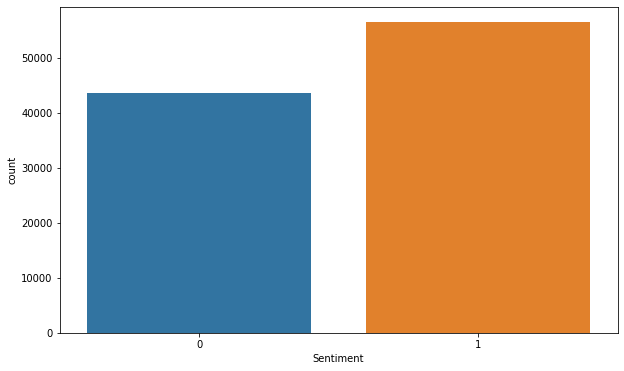

In [10]:
plt.figure(figsize = (10,6))
se.countplot(Y)

### Data Splitting
Since we are using a univariate dataset, we can directly split our data into training and testing subsets. The first subset is utilized to fit/train the model. The second subset is used for prediction. The main motive is to estimate the performance of the model on new data.

In [11]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=123)

### Feature Transformation

**TfidfVectorizer** converts a collection of raw documents to a matrix of TF-IDF features.

It's equivalent to CountVectorizer followed by TfidfTransformer.

***For more information on TfidfVectorizer [click here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)***

In [12]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)

x_train = vectorizer.transform(x_train)
x_test  = vectorizer.transform(x_test)

#### Handling Target Imbalance
The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important.

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class.We will perform overspampling using imblearn library.

In [13]:
x_train,y_train = RandomOverSampler(random_state=123).fit_resample(x_train, y_train)

## Model

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.

A Support Vector Machine is a discriminative classifier formally defined by a separating hyperplane. In other terms, for a given known/labelled data points, the SVM outputs an appropriate hyperplane that classifies the inputted new cases based on the hyperplane. In 2-Dimensional space, this hyperplane is a line separating a plane into two segments where each class or group occupied on either side.

Linear Support Vector Classification.

Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.

This class supports both dense and sparse input and the multiclass support is handled according to a one-vs-the-rest scheme.


#### Model Tuning Parameters
 **penalty** :{‘l1’, ‘l2’}, default=’l2’
Specifies the norm used in the penalization. The ‘l2’ penalty is the standard used in SVC. The ‘l1’ leads to coef_ vectors that are sparse.

**loss** : {‘hinge’, ‘squared_hinge’}, default=’squared_hinge’
Specifies the loss function. ‘hinge’ is the standard SVM loss (used e.g. by the SVC class) while ‘squared_hinge’ is the square of the hinge loss. The combination of penalty='l1' and loss='hinge' is not supported.

**C**: float, default=1.0
Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive.

**tol** : float, default=1e-4
Tolerance for stopping criteria.

**random_state** : int, RandomState instance or None, default=None
Controls the pseudo random number generation for shuffling the data for the dual coordinate descent (if dual=True). When dual=False the underlying implementation of LinearSVC is not random and random_state has no effect on the results. Pass an int for reproducible output across multiple function calls. See Glossary.

[For more information](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

In [14]:
model=LinearSVC(random_state=123)
model.fit(x_train,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=123, tol=0.0001,
          verbose=0)

#### Model Accuracy
score() method return the mean accuracy on the given test data and labels.

In multi-label classification, this is the subset accuracy which is a harsh metric since you require for each sample that each label set be correctly predicted.

In [15]:
print("Accuracy score {:.2f} %\n".format(model.score(x_test,y_test)*100))

Accuracy score 73.40 %



#### Confusion Matrix
A confusion matrix is utilized to understand the performance of the classification model or algorithm in machine learning for a given test set where results are known.

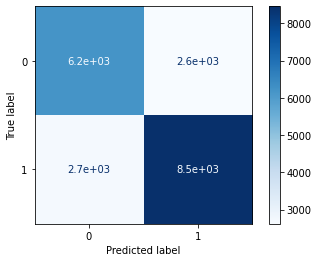

In [16]:
plot_confusion_matrix(model,x_test,y_test,cmap=plt.cm.Blues)

#### Classification Report
A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True, how many are False.
* where:
  - Precision:- Accuracy of positive predictions.
  -  Recall:- Fraction of positives that were correctly identified.
  -  f1-score:- percent of positive predictions were correct
  -  support:- Support is the number of actual occurrences of the class in the specified dataset.

In [17]:
print(classification_report(y_test,model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70      8840
           1       0.76      0.76      0.76     11158

    accuracy                           0.73     19998
   macro avg       0.73      0.73      0.73     19998
weighted avg       0.73      0.73      0.73     19998



#### Creator: Vikas Mishra , Github: [Profile](https://github.com/Vikaas08)